In [1]:
import pybamm
import numpy as np 
import matplotlib.pyplot as plt
import pickle
from joblib import Parallel, delayed
from jupyterthemes import jtplot
jtplot.style(theme="monokai", context="notebook", ticks=True, grid=False)
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

from IPython.display import Audio
url = "https://proxy.notificationsounds.com/wake-up-tones/you-have-new-message-484/download/file-a1_ascendent-64kbps.mp3"
notify=Audio(url = url, autoplay = True)

########## pickle commands for dumping and retrieving data #######
# filename = 'dogs'
# outfile = open(filename,'wb')
# pickle.dump(dogs_dict,outfile)
# outfile.close()
# infile = open(filename,'rb')
# data = pickle.load(infile)
# infile.close()

########### parallel computations command ####################
# data = Parallel(n_jobs=-1)(delayed(my_function)(i) for i in my_iterable)

In [2]:
# get experimental data
filename = '/home/drmrfc/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
infile = open(filename,'rb')
data_dict = pickle.load(infile)
infile.close()

discharge_data = data_dict['discharge']
charge_data = data_dict['charge']

temp_list = list(discharge_data.keys())

In [3]:
S8_initial_g = 2.6565990721396795
S6_initial_g = 0.03308746536461487
S4_initial_g = 0.013008078277994115
S2_initial_g = 2.8449317677625998e-08
S1_initial_g = 4.404388467562549e-12
Sp_initial_g = 2.6636551382083317e-06

# the total active material mass
m_s = S8_initial_g + S6_initial_g + S4_initial_g + S2_initial_g + S1_initial_g + Sp_initial_g

# get the mass fractions of the initial conditions
S8_initial_frac = S8_initial_g/m_s
S6_initial_frac = S6_initial_g/m_s
S4_initial_frac = S4_initial_g/m_s
S2_initial_frac = S2_initial_g/m_s
S1_initial_frac = S1_initial_g/m_s
Sp_initial_frac = Sp_initial_g/m_s

# set new total activate material mass to give Hunt's 0.211 Ah cell capacity
m_s_hunt = .168*1.5

# define the current for later simulations
current = 0.0211*2

# define discharge time in seconds for later simulations
hours = 10/2
time_in_seconds = hours*3600

S8_initial_hunt = S8_initial_frac*m_s_hunt*3
S6_initial_hunt = S6_initial_frac*m_s_hunt
S4_initial_hunt = S4_initial_frac*m_s_hunt
S2_initial_hunt = S2_initial_frac*m_s_hunt
S1_initial_hunt = S1_initial_frac*m_s_hunt
Sp_initial_hunt = Sp_initial_frac*m_s_hunt
V_initial_hunt = 2.4

# these are global variables to avoid needing to input them 
# we are not fitting initial conditions yet
discharge_initial_data = [V_initial_hunt, 
        S8_initial_hunt, 
        S6_initial_hunt,
        S4_initial_hunt, 
        S2_initial_hunt, 
        S1_initial_hunt, 
        Sp_initial_hunt]

gamma_space = [1]#np.linspace(0.1,5,5)
kappa_space = [1]#np.linspace(0.1,5,5)
data = {}
for gamma in gamma_space:
    for kappa in kappa_space:
        key = str(gamma) + ' ' + str(kappa)
        print('\n\n\n\n\n' + key + '\n\n\n\n\n')
        try:
            model = pybamm.lithium_sulfur.Cornish_concentration()

            # (similar) parameters should be the same as in Marinescu et al. (2018)
            # However, the  initial condition from charge appears to be the result of a discharge
            current = 2*0.0211
            hours = 15
            time_in_seconds = 6630# 8000#hours*3600
            params = model.default_parameter_values
            params.update(
                {
                    "Current function [A]": current,
                    "Initial Condition for S8 ion [g]": discharge_initial_data[1],
                    "Initial Condition for S6 ion [g]": discharge_initial_data[2],
                    "Initial Condition for S4 ion [g]": discharge_initial_data[3],
                    "Initial Condition for S2 ion [g]": discharge_initial_data[4],
                    "Initial Condition for S ion [g]": discharge_initial_data[5],
                    "Initial Condition for Precipitated Sulfur [g]": discharge_initial_data[6],
                    "Initial Condition for Terminal Voltage [V]": 2.4,#V_initial,
                    #"Precipitation rate [s-1]": 50,
                    #"Shuttle rate coefficient during discharge [s-1]": 0.0002,
                    "Lower voltage cut-off [V]": 2.39,
                    "Upper voltage cut-off [V]": 2.6,
                    "Standard Potential L [V]": 2.0,
                    "Standard Potential M [V]": 2.0,
                    "Standard Potential H [V]": 2.38,
                    "gamma": gamma,
                    "kappa" : kappa,
                    #"S saturation mass [g]": 1e-6,
                    #"Electrolyte volume per cell [L]": 0.0114*.25
                }
            )
            params.process_model(model)
            sim_cornish_discharge_base = pybamm.Simulation(
                model,
                parameter_values=params,
                solver=pybamm.CasadiSolver(
                    atol=1e-6, 
                    rtol=1e-3, 
                    extra_options_setup={"max_step_size": 0.1}, 
                    max_step_decrease_count = 15,
                    #root_method = 'lm',
                    #root_tol = 1e-7, 
                    #dt_max = 1e-7
                ),
            )
            sim_cornish_discharge_base.solve(np.linspace(0, time_in_seconds, 100))
            key = str(gamma) + ' ' + str(kappa)
            voltage_cornish_discharge_base = sim_cornish_discharge_base.solution['Terminal voltage [V]'].entries
            capacity_cornish_discharge_base = abs(current)*sim_cornish_discharge_base.solution.t/3600
            data[key] = (capacity_cornish_discharge_base, voltage_cornish_discharge_base)
        except:
            print("\n\n\n\n\n Failure! \n\n\n\n\n")






1 1







psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

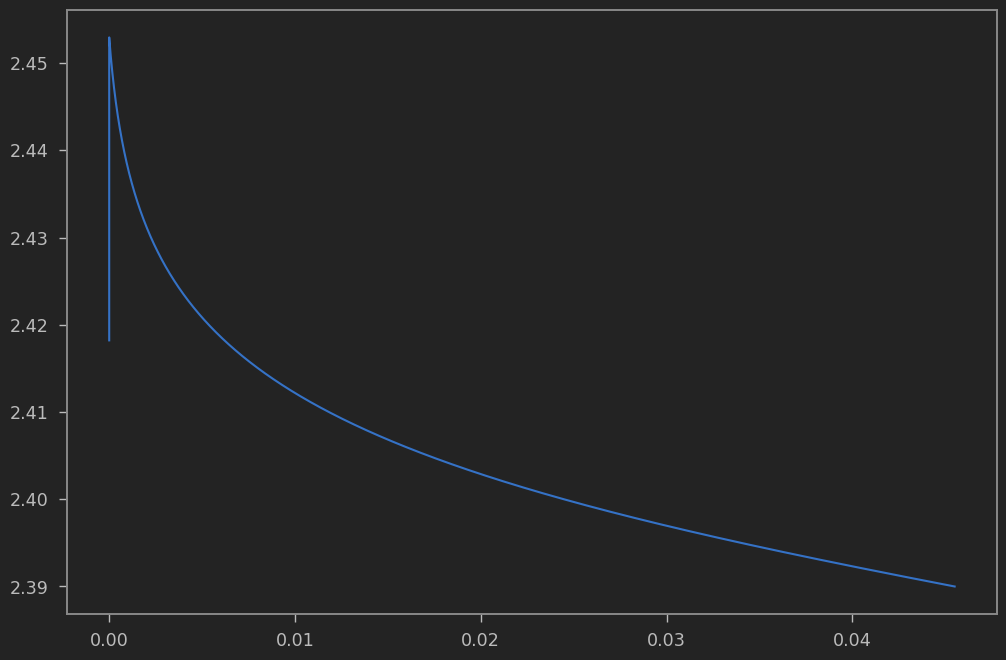

In [4]:
for key in data.keys():
    plt.plot(data[key][0],data[key][1])
    
notify

In [5]:
S8 = sim_cornish_discharge_base.solution['S8 [g]'].entries
S6 = sim_cornish_discharge_base.solution['S6 [g]'].entries
S4 = sim_cornish_discharge_base.solution['S4 [g]'].entries
S2 = sim_cornish_discharge_base.solution['S2 [g]'].entries
S1 = sim_cornish_discharge_base.solution['S [g]'].entries
Sp = sim_cornish_discharge_base.solution['Precipitated Sulfur [g]'].entries
V = sim_cornish_discharge_base.solution['Terminal voltage [V]'].entries

S8_initial = S8[V <= 2.4][0]
S6_initial = S6[V <= 2.4][0]
S4_initial = S4[V <= 2.4][0]
S2_initial = S2[V <= 2.4][0]
S1_initial = S1[V <= 2.4][0]
Sp_initial = Sp[V <= 2.4][0]

In [6]:
gamma_space = [4,5,6]
kappa_space = [7,8,9]
data = {}
for gamma in gamma_space:
    for kappa in kappa_space:
        key = str(gamma) + ' ' + str(kappa)
        print('\n\n\n\n\n' + key + '\n\n\n\n\n')
        try:
            model = pybamm.lithium_sulfur.Cornish_concentration()

            # (similar) parameters should be the same as in Marinescu et al. (2018)
            # However, the  initial condition from charge appears to be the result of a discharge
            current = 2*0.0211
            hours = 15
            time_in_seconds = 4700# 8000#hours*3600
            params = model.default_parameter_values
            params.update(
                {
                    "Current function [A]": current,
                    "Initial Condition for S8 ion [g]": S8_initial,
                    "Initial Condition for S6 ion [g]": S6_initial,
                    "Initial Condition for S4 ion [g]": S4_initial,
                    "Initial Condition for S2 ion [g]": S2_initial,
                    "Initial Condition for S ion [g]": S1_initial,
                    "Initial Condition for Precipitated Sulfur [g]": Sp_initial,
                    "Initial Condition for Terminal Voltage [V]": 2.4,#V_initial,
                    #"Precipitation rate [s-1]": 50,
                    #"Shuttle rate coefficient during discharge [s-1]": 0.0002,
                    "Lower voltage cut-off [V]": 2.0,
                    "Upper voltage cut-off [V]": 2.6,
                    "Standard Potential L [V]": 2.0,
                    "Standard Potential M [V]": 2.0,
                    "Standard Potential H [V]": 2.38,
                    "gamma": gamma,
                    "kappa" : kappa,
                    #"S saturation mass [g]": 1e-6,
                    #"Electrolyte volume per cell [L]": 0.0114*.25
                }
            )
            params.process_model(model)
            sim_cornish_discharge_base = pybamm.Simulation(
                model,
                parameter_values=params,
                solver=pybamm.CasadiSolver(
                    atol=1e-6, 
                    rtol=1e-3, 
                    extra_options_setup={"max_step_size": 0.1}, 
                    max_step_decrease_count = 15,
                    #root_method = 'lm',
                    #root_tol = 1e-7, 
                    #dt_max = 1e-7
                ),
            )
            sim_cornish_discharge_base.solve(np.linspace(0, time_in_seconds, 100))
            key = str(round(gamma,2)) + ' ' + str(round(kappa,2))
            voltage_cornish_discharge_base = sim_cornish_discharge_base.solution['Terminal voltage [V]'].entries
            capacity_cornish_discharge_base = abs(current)*sim_cornish_discharge_base.solution.t/3600
            data[key] = (capacity_cornish_discharge_base, voltage_cornish_discharge_base)
        except:
            print("\n\n\n\n\n Failure! \n\n\n\n\n")






4 7







psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c






4 8







psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundial






4 9







psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c






5 7







psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup fai

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup fai






5 8







psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c






5 9







psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup fai

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup fai

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed







6 7







psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c






6 8







psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_i






6 9







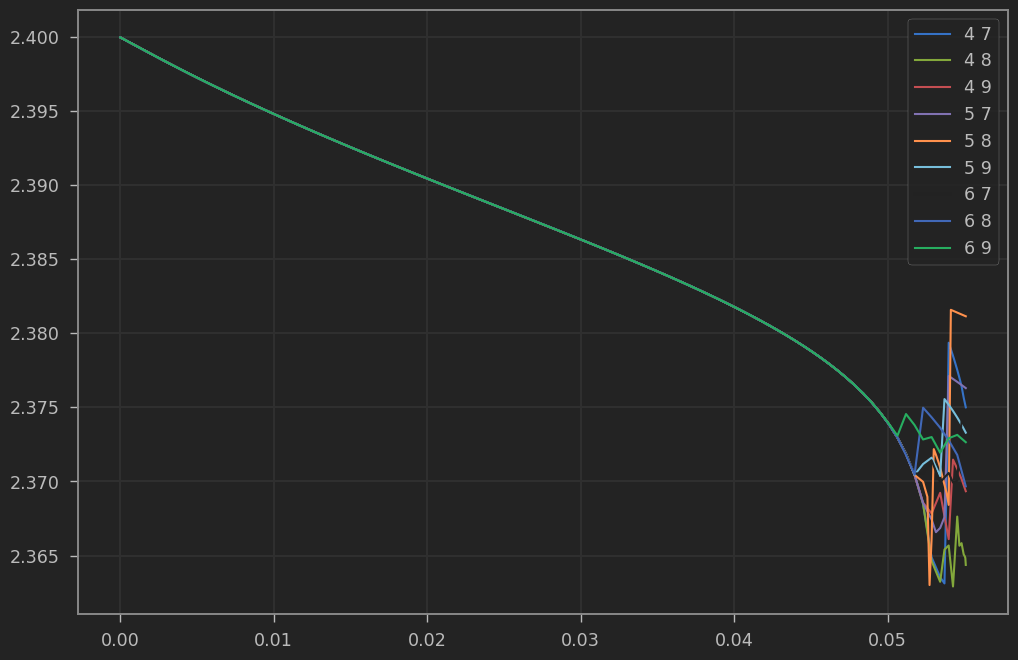

In [7]:
#plt.plot(discharge_data['30']['capacity'],discharge_data['30']['internal voltage'])
#legend = ['experiment']
legend = []
for key in data.keys():
    plt.plot(data[key][0],data[key][1])
    legend.append(key)

plt.legend(legend)
#plt.ylim([1.4,2.5])
plt.grid(True)
notify 

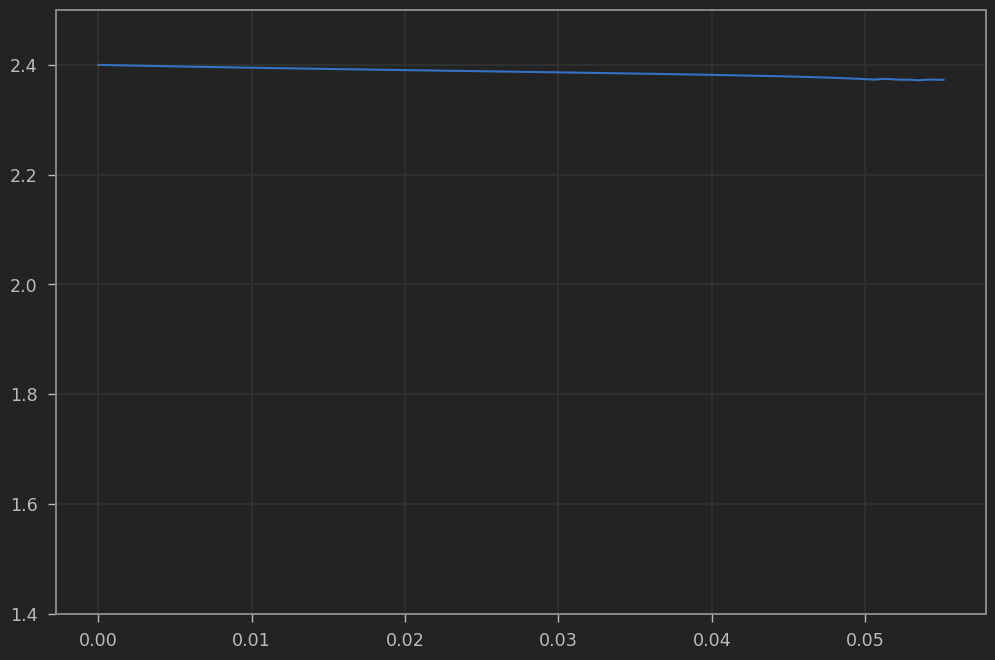

In [8]:
voltage_cornish_discharge_base = sim_cornish_discharge_base.solution['Terminal voltage [V]'].entries
capacity_cornish_discharge_base = abs(current)*sim_cornish_discharge_base.solution.t/3600
plt.plot(capacity_cornish_discharge_base,voltage_cornish_discharge_base)
plt.ylim([1.4,2.5])
plt.grid(True)
notify

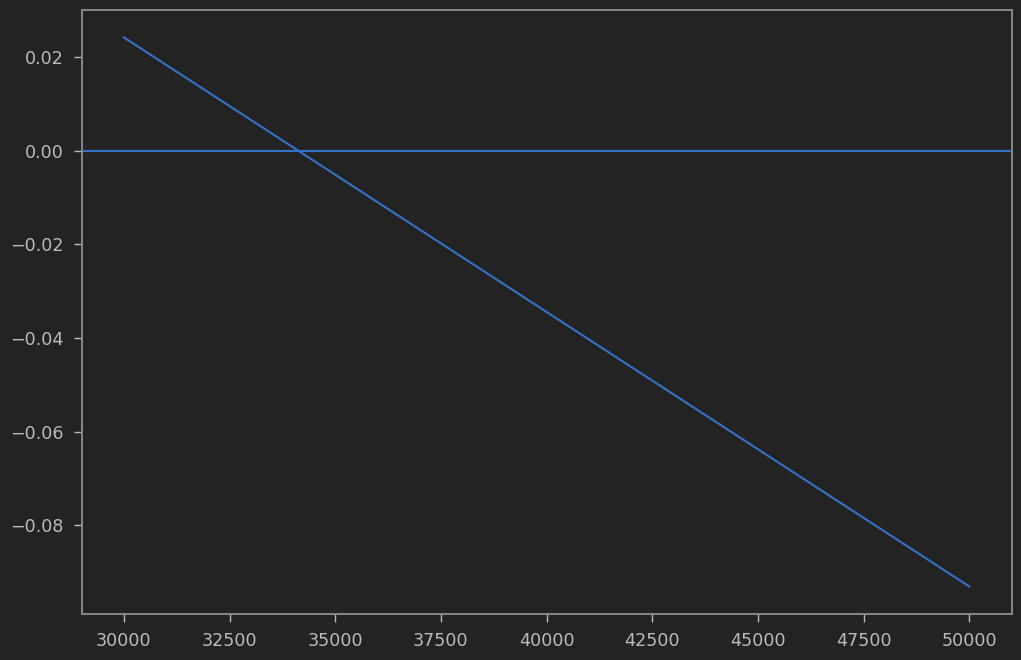

In [17]:
x = np.linspace(30000,50000,1000)
plt.plot(x, .2 - 0.0211*(x/3600))
plt.axhline(0)